# Gibbs sampling

This practical demonstration is based on the material covered by Prof. Saad Jbabdi [here](https://users.fmrib.ox.ac.uk/~saad/ONBI/bayes_practical.html#sampling)

## Problam Statement

Consider a model with parameter set: 

$$ \mathbf{\theta} = \{\theta_{1},...,\theta_{n}\} $$

that generate some data $\mathbf{y}$.

Gibbs sampling is method of approximating the posterior for each $\theta$ by sampling from their respective conditional probabilities. For example: 

$$ p(\theta_{j} \mid \theta_{-j}^{t-1}, \mathbf{y}) $$

Where $\theta_{-j}^{t-1}$ is an enumeration of all parameters $\theta$ except $\theta_{j}$. 

As a first example, we will investigate a Gibbs sampler from a bivariate normal distribition: 

$$\binom{\theta_{1}}{\theta_{2}} \mid \mathbf{y} \sim \mathcal{N}(\binom{y_{1}}{y_{2}}, \left(\begin{array}{cc} 1 & \rho\\\rho & 1\end{array}\right)) $$

This can done analytically, however, this is of little interest right now. 

The conditional posteriors for each parameter can be given by: 

$$ \theta_{1} \mid \theta{2}, \mathbf{y} \sim \mathcal{N}(y_{1} + \rho(\theta_{2} - y_{2}), 1 - \rho^{2}) $$
$$ \theta_{2} \mid \theta{1}, \mathbf{y} \sim \mathcal{N}(y_{2} + \rho(\theta_{1} - y_{1}), 1 - \rho^{2}) $$

Note that the conditional posteriors of the multivariate distributions can be approximated by a normal distribution.

For the derivation of these conditional posteriors, see here. (link to be added later). 


In [ ]:



θ |θ , y~N(y +ρ(θ −y ), 1−ρ2) 2
θ1|θ2, y~N(y1+ρ(θ2−y2), 1−ρ ).

We consider a linear model: 

$$ y = ax + \epsilon$$ 

$$ \epsilon = \mathcal{N}(0, \sigma^{2}) $$ 
where, y is the data, x is a regressor, a is an unknown parameter and $\epsilon$ is noise assumed to be $\mathcal{N}(0, \sigma^{2})$, where $\sigma^{2}$ is the unknown variance. 

We wish to estimate the parameter unknown parameter $a$ that generates the data $y$, accounting for $x$ and $\epsilon$.
 
Gibbs sampling stautes that we can obtain the posterior for each unkown parameter by sampling from their respective conditional posteriors. 
We begin by generating some data.

## Generating Data

We generate some datat that obeys the generative model above. 

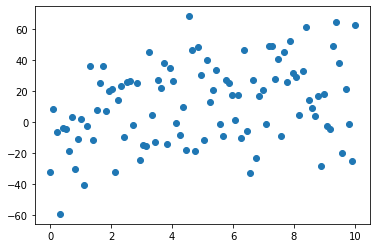

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Specify initial values

true_value = 2 # parameter a
sigma = 5      # true sigma
x = np.linspace(0,10,100) # known regressor
n = len(x) 


# Generate data

y = true_value * x + np.random.normal(0,np.power(sigma,2),n)

# Plot synthetic data

plt.scatter(x,y)
plt.show()

To complete the generative model, we place the following priors on $a$ and uniform priors on $\sigma^{2}$:

$$P(s^2)=1/s^{2}$$

$$P(a)=\mathcal{N}(0,\sigma_{0}^{2})$$

In [104]:
va = np.linspace(0,5,100)
vs = np.linspace(0.01,80,100)

posterior = np.zeros((len(vs),len(va)))

for i in range(100):
    for j in range(100):
        sample = va[j]*x
        likelihood = np.power(vs[i], -n/2) * np.exp(-1* np.sum(np.power((y - sample),2)) / 2/vs[i])


In [ ]:
 % grid
  va = linspace(0,5,100);     % values of a
  vs = linspace(.01,80,100);  % values of s^2

  posterior = zeros(length(vs),length(va));

  for i=1:length(vs)
   for j=1:length(va)
    S  = va(j)*t;                                        % prediction
    li = vs(i).^(-n/2)*exp(-sum((y-S).^2)/2/vs(i));      % likelihood
    pr = 1/vs(i) * normpdf(va(i),0,1000);                % prior
    posterior(i,j) = li*pr;                              % posterior
   end
  end
  posterior = posterior / sum(posterior(:));
  